In [7]:
import os
import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

import open_clip
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# pick which 
# model you want
model_name = "ViT-B-32"
pretrained = "openai"

# this returns (model, preprocess_transforms)
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

/home/maker/.conda/envs/appliedAI/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

In [2]:
# Paths
train_dir = Path("brain-tumor-dataset/Training")
test_dir = Path("brain-tumor-dataset/Testing")

# Dataset objects
train_ds = ImageFolder(train_dir, transform=preprocess)
test_ds = ImageFolder(test_dir, transform=preprocess)

# Optionally split training further into train/val
val_size = int(0.1 * len(train_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# Class names
classes = train_ds.dataset.classes  # from ImageFolder
print("Detected classes:", classes)

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Prompt embedding for classes

prompts = [f"an MRI scan showing a {c}" for c in classes]

text_inputs = torch.cat([open_clip.tokenize(p) for p in prompts]).to(DEVICE)

with torch.no_grad():
    text_embeddings = model.encode_text(text_inputs)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)


In [4]:
# Training Loop

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=1e-4)
temperature = nn.Parameter(torch.tensor(0.07)).to(DEVICE)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    losses = []
    accuracies = []
    
    num_samples = len(train_loader.dataset)
    processed = 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Encode images
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Compute similarity logits
        logits = (image_features @ text_embeddings.T) / temperature

        loss = nn.CrossEntropyLoss()(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        
        processed += images.size(0)
        print(f"\rProcessing image {processed}/{num_samples}", end="")  # \r overwrites the line


    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {np.mean(losses):.4f}")

    # Validation accuracy
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            feats = model.encode_image(images)
            feats /= feats.norm(dim=-1, keepdim=True)
            logits = (feats @ text_embeddings.T) / temperature
            preds = logits.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    accuracies.append(acc)
    print("Validation accuracy:", acc)

Processing image 5141/5141Epoch 1/5 - Train loss: 0.4374
Validation accuracy: 0.9754816112084063
Processing image 5141/5141Epoch 2/5 - Train loss: 0.1129
Validation accuracy: 0.9719789842381786
Processing image 5141/5141Epoch 3/5 - Train loss: 0.0619
Validation accuracy: 0.9702276707530648
Processing image 5141/5141Epoch 4/5 - Train loss: 0.0650
Validation accuracy: 0.9614711033274956
Processing image 5141/5141Epoch 5/5 - Train loss: 0.0593
Validation accuracy: 0.9824868651488616


Classification Report:
              precision    recall  f1-score   support

      glioma       0.24      0.93      0.38       300
  meningioma       0.22      0.04      0.07       306
     notumor       0.00      0.00      0.00       405
   pituitary       0.10      0.03      0.05       300

    accuracy                           0.23      1311
   macro avg       0.14      0.25      0.13      1311
weighted avg       0.13      0.23      0.12      1311



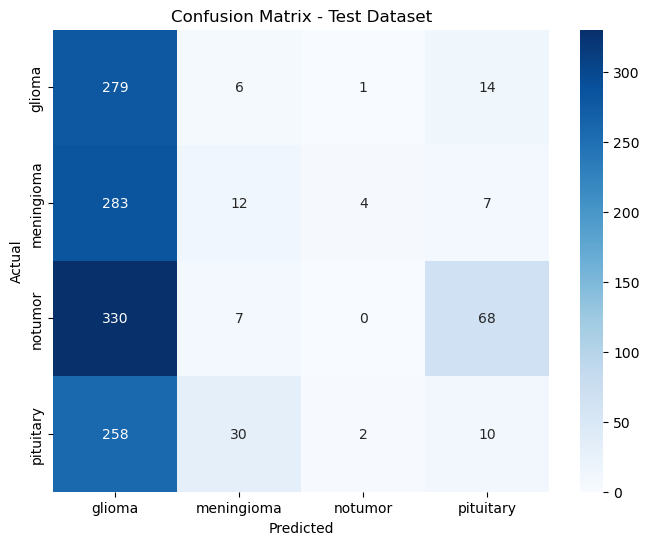

In [10]:
# Make sure the model is in evaluation mode
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():  # disables gradient computation to save memory
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        # Encode images
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        # Compute logits against text embeddings
        logits = (image_features @ text_embeddings.T) / temperature
        preds = logits.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Dataset')
plt.show()

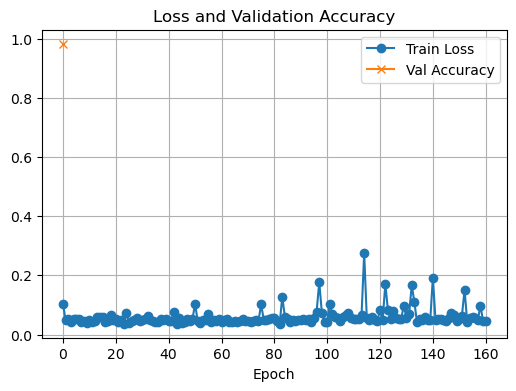

In [9]:
plt.figure(figsize=(6,4))
plt.plot(losses, label='Train Loss', marker='o')
plt.plot(accuracies, label='Val Accuracy', marker='x')
plt.xlabel('Epoch')
plt.legend()
plt.title('Loss and Validation Accuracy')
plt.grid(True)
plt.show()
